## Document dependencies
Skip this section. To document the dependencies, execute the following cells after executing all relevant import statements.

In [ ]:
!pip install --user watermark

In [3]:
%load_ext watermark
print()
%watermark -v
print()
%watermark -iv


CPython 3.7.4
IPython 7.8.0

numpy  1.18.5
pandas 0.25.1



## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pre-processing

This notebook contains the pre-processing of Annie's EbolaDatabase for the purposes of the semester project. These purposes are:
- To replicate some of the prediction models described in her 2017 papers, in the centralized as well as various simulated distributed ML settings.
- To define other models, if they can be useful to benchmark model personalisation / data selection schemes.

# 1. Read the raw EbolaDatabase

In [2]:
df = pd.read_csv("../data/private/0_raw_EbolaDatabase.csv")
df_in = df.copy()

Let me show you something: **study_id 125 is missing**. That's not really problematic, but _do not_ use `study_id` as index!

In [3]:
df_in.study_id[123:128]

123    124
124    126
125    127
126    128
127    129
Name: study_id, dtype: int64

In [4]:
df.iloc[:0, :20] # DO NOT PUSH A COMMIT WHERE ANY LINE IS VISIBLE!

,study_id,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,date_admis,temp_triage,pyrexia_triage,anuria_triage,dyspnea_triage,disorientation_triage,headache_triage,hiccups_triage,myalgia_triage,rash_triage


# 2. Missing values

Missing values must be dealt with, in one way or another, for all features that will be used in machine learning models.

In [5]:
print(df.shape)
# Show which columns contain any NA values:
df.isna().any().to_frame().T

(575, 67)


,study_id,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,...,hemoptysis_after,hematochezia_after,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after
0,False,False,True,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [6]:
df.columns

Index(['study_id', 'evd', 'evd_ct', 'malaria', 'death', 'sex', 'age',
       'quarantine', 'days_admitted', 'referral_time', 'date_admis',
       'temp_triage', 'pyrexia_triage', 'anuria_triage', 'dyspnea_triage',
       'disorientation_triage', 'headache_triage', 'hiccups_triage',
       'myalgia_triage', 'rash_triage', 'dysphagia_triage', 'asthenia_triage',
       'abdomnial_triage', 'anorexia_triage', 'diarrhea_triage',
       'diarrhea_score_triage', 'vomiting_triage', 'hemorrhage_triage',
       'orl_hemorrhage_triage', 'conjonctivitis_triage', 'hemoptysis_triage',
       'hematochezia_triage', 'hematuria_triage', 'gynec_hemorrhage_triage',
       'num_hemorrhages_triage', 'mult_hemorrhage_triage',
       'dehydration_triage', 'hepatomegaly_triage', 'jaundice_triage',
       'edema_triage', 'splenomegaly_triage', 'anuria_after', 'dyspnea_after',
       'disorientation_after', 'headache_after', 'hiccups_after',
       'myalgia_after', 'rash_after', 'dysphagia_after', 'asthenia_afte

In [7]:
df[df.columns[df.isna().any()]].isna().sum().to_frame().T

,evd_ct,malaria,quarantine,referral_time
0,431,32,24,87


In [8]:
print("evd_ct is available for {ct} of the {pos} EVD+ patients.".format(
        ct=len(df) - df['evd_ct'].isna().sum(),
        pos=df['evd'].sum()
))

evd_ct is available for 144 of the 158 EVD+ patients.


The first four columns are the most obvious targets (`evd`, `evd_ct`, `malaria` and `death`).
The first three could be particularly useful in predicting `death`.

Every patient admitted to the ETC was tested for Ebola (column `evd`).
`evd_ct` (inversely proportional to the viral load) is missing for all EVD- patients and for 14 EVD+ patients.
Malaria test results are missing for 32 patients.

## 2.1. Referral time

Annie's paper mentions 20 missing values for the referral time, which were tested to be likely missing completely at random (MCAR).
She transforms this into the binary variable $\mathbb{1}\left\{ x \in [4, 9] \right\}$ ($x \triangleq$ referral time in days).
Let's plot the proportion of EVD(+) as a function of referral time, along with confidence intervals (a Wilson score interval obtained by assuming that the EVD diagnosis follows a Bernoulli distribution whose probability depends on the referral time).

In [9]:
df_ref = df['evd'].to_frame()
df_ref['referral_time'] = df['referral_time'].astype(str).apply(
        lambda s: s[:-2] if ('na' in s.lower() or len(s)==4) else '0'+s[:-2]
)
df_ref['total'] = 1
df_ref.head()

,evd,referral_time,total
0,1,12,1
1,1,n,1
2,1,06,1
3,1,01,1
4,1,n,1


Text(0, 0.5, 'number of patients')

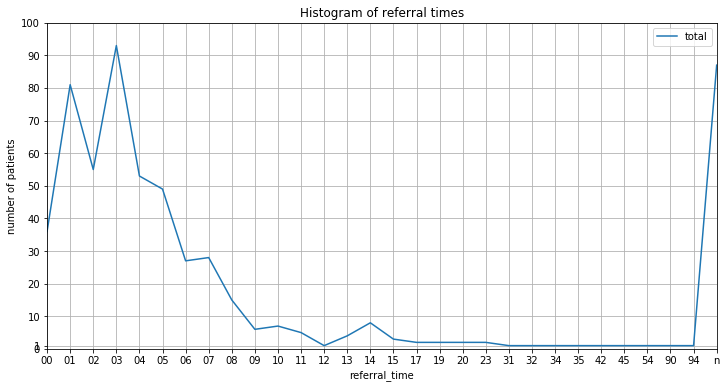

In [10]:
df_ref = df_ref.groupby('referral_time').sum()
df_ref.plot(y='total', xticks=range(len(df_ref)), figsize=(12,6), grid=True, ylim=(0,100), yticks=[0,1]+list(range(10,101, 10)), title='Histogram of referral times')
plt.ylabel("number of patients")

On second thought, these intervals (and also the proportion of EVD(+) patients in each `referral_time` category) will be near meaningless, considering the small number of samples per category.
Instead, we follow Annie in replacing the referral_time by a binary variable (cf. previous Markdown cell).
In this new binary feature, we replace `NaN`s by the proportion of `1`s among available values.
With this, the feature is no longer truly binary, but can instead be interpreted as an a-priori probability of having a referral time in between 4 and 9 days.
This probability is exactly 1 or 0 for all patients whose referral time is known.

In [11]:
df['referral(4-9)'] = ((df['referral_time'] <= 9) & (df['referral_time'] >= 4)).astype(np.float32)
np.where(np.isnan(df['referral_time']))[0]

array([  1,   4,   9,  16,  52,  75,  81,  83,  93,  98, 102, 125, 132,
       133, 138, 141, 143, 144, 150, 151, 152, 154, 156, 167, 168, 172,
       183, 192, 211, 217, 218, 233, 236, 237, 238, 244, 245, 247, 248,
       253, 278, 279, 290, 300, 301, 307, 311, 317, 322, 327, 335, 336,
       355, 357, 360, 363, 368, 395, 396, 398, 399, 402, 410, 411, 412,
       416, 421, 435, 441, 449, 451, 453, 454, 460, 464, 478, 483, 485,
       487, 492, 502, 515, 518, 524, 542, 545, 561])

In [12]:
df.loc[ np.where(np.isnan(df['referral_time']))[0] , 'referral(4-9)'] = float('NaN')
df.loc[122:133, [ 'study_id', 'referral_time', 'referral(4-9)']].T

,122,123,124,125,126,127,128,129,130,131,132,133
study_id,123.0,124.0,126.0,127.0,128.0,129.0,130.0,131.0,132.0,133.0,134.0,135.0
referral_time,5.0,5.0,6.0,NaN,3.0,1.0,6.0,3.0,5.0,4.0,NaN,NaN
referral(4-9),1.0,1.0,1.0,NaN,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN


In [13]:
df.loc[ np.where(np.isnan(df['referral_time']))[0] , 'referral(4-9)'] = df['referral(4-9)'].mean()
print(df['referral(4-9)'].isna().any())
df.loc[122:133, [ 'study_id', 'referral_time', 'referral(4-9)']].T

False


,122,123,124,125,126,127,128,129,130,131,132,133
study_id,123.0,124.0,126.0,127.000000,128.0,129.0,130.0,131.0,132.0,133.0,134.000000,135.000000
referral_time,5.0,5.0,6.0,NaN,3.0,1.0,6.0,3.0,5.0,4.0,NaN,NaN
referral(4-9),1.0,1.0,1.0,0.364754,0.0,0.0,1.0,0.0,1.0,1.0,0.364754,0.364754


## 2.2. Quarantine

The single most useful feature in the predictive models described in Annie's papers is whether or not the patient had had contact with a confirmed EVD patient.
All those known to have had contact with confirmed EVD patients, underwent a quarantine (often together in groups).
Thus, the `quarantine` column can be interpreted as "We know that this patient has had contact with a confirmed EVD patient".

Unfortunately, 24 patients do not have an entry in this column.
In principle, this means _we do not know whether this patient has had contact with a confirmed EVD patient_.
What we do with these missing values largely depends on how the data for this feature was gathered.

Below, we perform a visual inspection of how the missing values are distributed:
<!-- Even if the values are missing completely at random, the best way to fill missing values depends on which scenario we would rather believe:
- Of course, if the values are not missing completely at random, it might be useful to include a binary feature for whether or not the `quarantine` value is missing.
- Else, if we believe that nearly all individuals who have had contact with a confirmed EVD patient really underwent quarantine, then missing values should be replaced by the column mean.
- If, on the contrary, we believe that many (say, more than half) of the patients who have had contact with a confirmed EVD patient, are never found -->

In [14]:
df_quarantine_missing = df.iloc[ np.where(np.isnan(df['quarantine']))[0] , :].copy()
print(len(df_quarantine_missing))
df_quarantine_missing.head(0) # DO NOT PUSH A COMMIT WHERE ANY LINE IS VISIBLE!

24


,study_id,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,...,hematochezia_after,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after,referral(4-9)


In [15]:
df_quarantine_0 = df.loc[ df['quarantine'] == 0 , :].copy()
print(len(df_quarantine_0))
df_quarantine_0.quarantine.max()

415


0.0

In [16]:
df_quarantine_1 = df.loc[ df['quarantine'] == 1 , :].copy()
print(len(df_quarantine_1))
df_quarantine_1.quarantine.min()

136


1.0

In [17]:
non_binary_features = {'study_id', 'evd_ct', 'age', 'days_admitted', 'referral_time', 'date_admis', 'temp_triage', 'num_hemorrhages_triage', 'num_hemorrhage_sites_after'}

def compare_means(dfs, labels):
    dfs_binary = [df.drop(labels=non_binary_features.intersection(df.columns), axis=1) for df in dfs]
    
    interesting_non_binary = {'age', 'date_admis', 'study_id'}
    non_interesting_features = non_binary_features - interesting_non_binary
    if not all((set(df.columns) - non_interesting_features) == (set(dfs[0].columns) - non_interesting_features) for df in dfs):
        raise ValueError("The passed DataFrames do not have the same column labels.")
    if not all((df.columns == dfs_binary[0].columns).all() for df in dfs_binary):
        raise ValueError("The column labels of the passed DataFrames do not follow the same ordering.")
        
    fig, ax = plt.subplots(figsize=(25,7))
    xlabels = dfs_binary[0].columns.to_list()
    x = np.arange(len(xlabels))
    width = 0.75/len(dfs)
    for i, df in enumerate(dfs_binary):
        ax.bar(x + (i - len(dfs)/2.)*width, df.mean(axis=0), width, label=labels[i])
        
    ax.legend()
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_xlim((-1, len(xlabels)))
    ax.set_ylim((0,1))
    ax.set_ylabel("Proportion of `True`")
    plt.show()
    
    # The non-binary features `age` and `date_admis` could also revel, non-random missingness:
    fig, axs = plt.subplots(ncols=len(interesting_non_binary), figsize=(25,7))
    for ax, col_name in zip(axs.flat, interesting_non_binary):
        for df, label in zip(dfs, labels):
            ax.hist(df[col_name], label=label, histtype='step', density=True)
        ax.legend()
        ax.set_title(col_name + ' distribution')
        ax.set_xlabel("Age [years]" if col_name=='age' else "Month of 2015")
        ax.set_ylabel("Density")
    plt.show()
    return

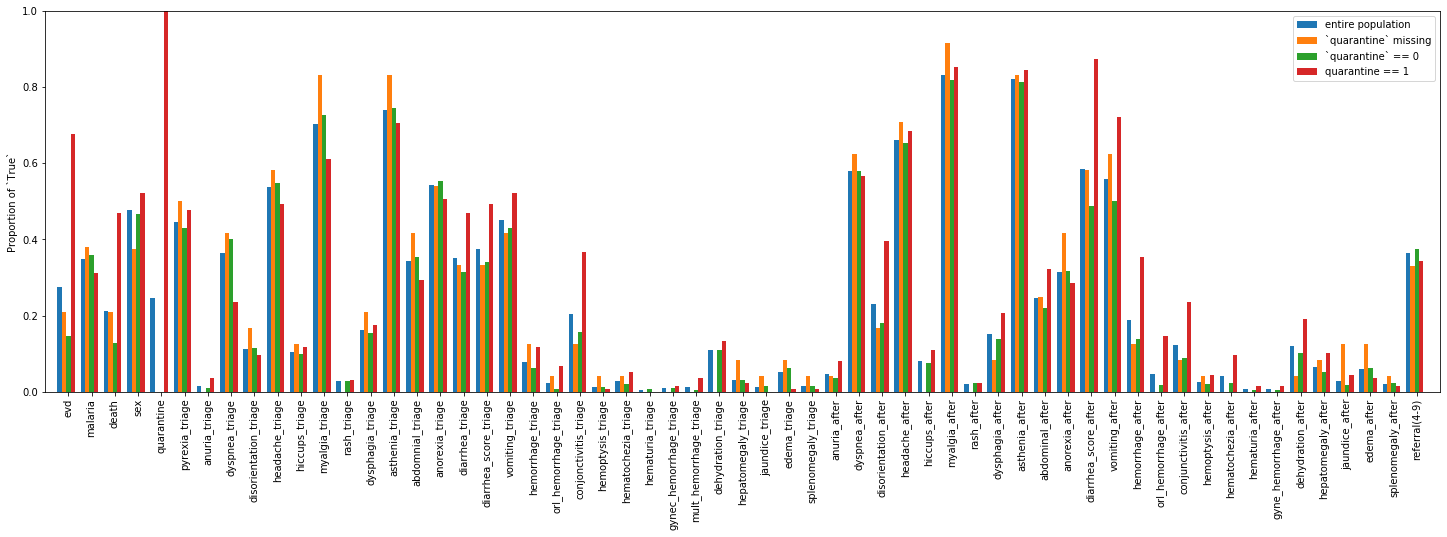

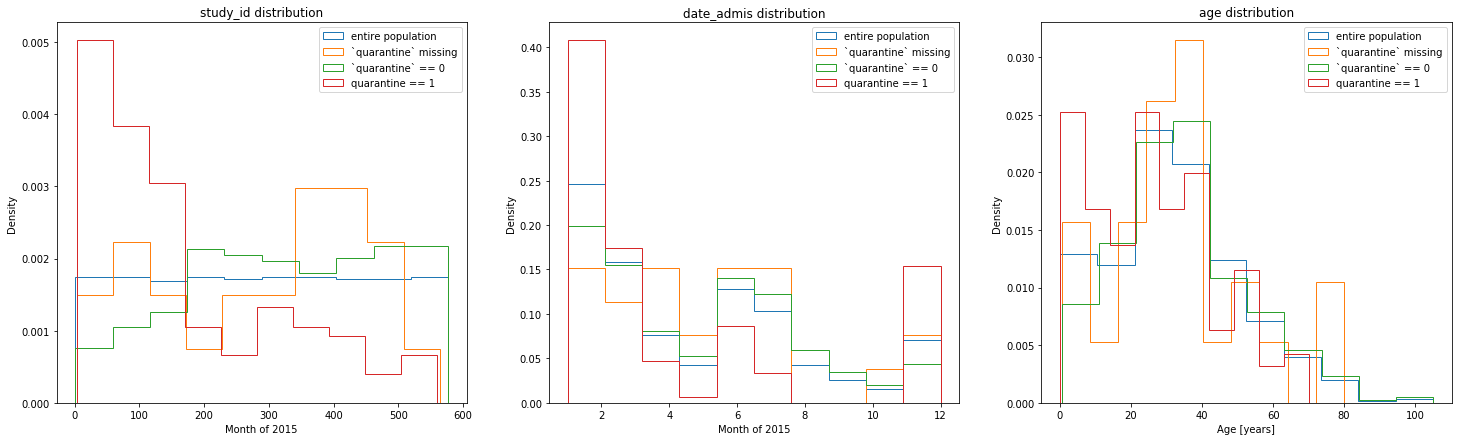

In [18]:
# ax = df_quarantine.drop(labels='study_id', axis=1).mean(axis=0).plot(kind='bar', figsize=(20, 6), grid=True, ylim=(0,1))
compare_means([df, df_quarantine_missing, df_quarantine_0, df_quarantine_1], ['entire population', '`quarantine` missing', '`quarantine` == 0', 'quarantine == 1'])


From the bar plot, we identify some features that correlate relatively strongly with quarantine (large discrepancy between `quarantine == 0` and `quarantine == 1`):
- evd
- death
- \* anuria
- \* dyspnea (only at triage)
- diarrhea
- vomiting
- oral hemorrhage
- \* conjunctivitis

We confirm our previous intuition that `NaN` values should not be replaced with `1`. While some features (highlighted with \*) seem to suggest that the `NaN` population is actually more alike to the `0` population, than to the entire population, this claim can not be made with any reasonable degree of confidence based on the low number of 24 samples with missing `quarantine` values.
In a situation like this, we would generally replace the missing values by the column mean due to the low number of missing samples.
As `quarantine` was shown to be the most predictive value, however, we might be justified to create a separate binary variable indicating whether the `quarantine` value was missing.
This has the effect that the model learns which value would have been most appropriate to replace missing values. This approach also captures the effect of any confounding variable that could be responsible for the missing values (and potentially affect the outcome for the patients), thus making it well-suited to deal with non-MCAR (missing _not_ completely at random) data.

In [19]:
assert df['quarantine'].isna().sum() > 0
df['quarantine_missing'] = df['quarantine'].isna().astype('int')
print(df['quarantine_missing'].sum())
df.loc[ np.where(np.isnan(df['quarantine']))[0] , 'quarantine'] = 0

24


In [20]:
df.head(0) # DO NOT PUSH A COMMIT WHERE ANY LINE IS VISIBLE!

,study_id,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,...,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after,referral(4-9),quarantine_missing


## Saving the result

In [60]:
df.to_csv('../data/private/1_TreatMissing_EbolaDatabase.csv')

# 3.

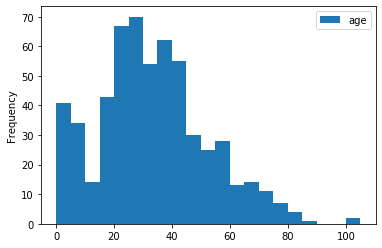

In [23]:
df.plot(y='age', kind='hist', bins=21)

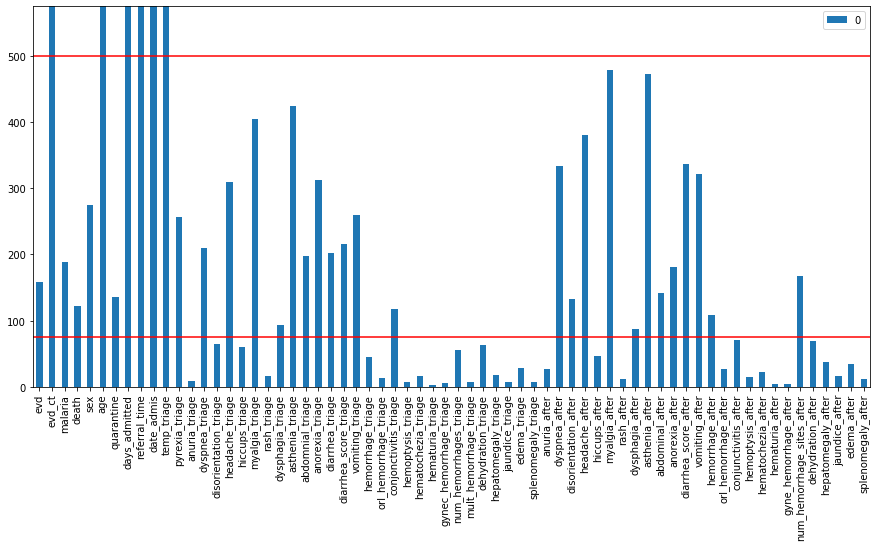

In [19]:
# Many columns are binary. Let's count the positives (meaningless for non-binary features):
df.sum().to_frame().plot(kind='bar', figsize=(15,7))
plt.gca().set_ylim((0, len(df)))
hline_limit = 75
plt.gca().axhline(y=hline_limit, color='r')
plt.gca().axhline(y=len(df) - hline_limit, color='r')
plt.show()

One possibility for dealing with continuous or ordered features for which values are missing not completely at random (not MCAR), at least for ridge or logistic regression:

1. Standardize the features if you're going to use regularization (and why wouldn't you)
2. Add a one-hot encoded feature "feature_XY_is_na" (this feature should be non-zero when the other feature _is_ missing).
3. Replace the na values by 0.

Result: one weight learns what to contribute to the model when the feature is na, and another learns what to do when it is available. This could, for instance, result in different intercepts for people with vs without missing value, which makes sense if the values are missing for some systematic reason. It's kind of a backwards logic of "if the Doctor didn't deem it useful to perform this test, that's probably because the person was fine" or something.

Main downside: If the number of missing values is low, 